In [405]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import string
import nltk
import spacy
from gensim import corpora
from gensim.models import LdaModel, Phrases, TfidfModel
from gensim.models.phrases import Phraser
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from tqdm import tqdm

from wordcloud import WordCloud

import matplotlib.colors as mcolors

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

nltk.download('punkt')
# !python3 -m spacy download en

[nltk_data] Downloading package punkt to /Users/marcus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [406]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)

color_pallete = sns.color_palette([grey, darkgreen, teal, blue, yellow])

# Feedback Analysis

In [407]:
feedback_df = pd.read_csv('../Menagerie/data/grades.csv', index_col=0)
feedback_df = feedback_df[~feedback_df['grade'].isnull()]
feedback_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++
16,353.0,NaN,Documentation,14,1,A++
17,422.0,NaN,Documentation,14,1,A++
18,480.0,NaN,Documentation,14,1,A++


## Summary Analysis
### Count of submissions with no feedback

In [408]:
count_df = feedback_df.groupby('skill').count().reset_index()
count_df['missing'] = count_df['assignment_number'] - count_df['comments']
count_df

,skill,assignment_number,comments,participant_id,batch,grade,missing
0,Code Elegance,1120,677,1120,1120,1120,443
1,Correctness,1116,714,1116,1116,1116,402
2,Documentation,1118,710,1118,1118,1118,408
3,Readability,1120,631,1120,1120,1120,489


<Axes: xlabel='skill', ylabel='missing'>

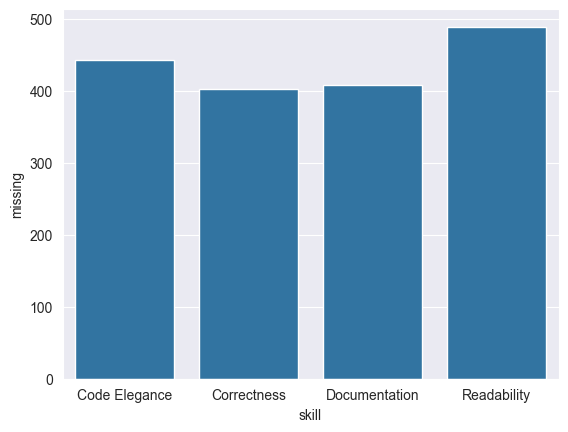

In [409]:
# Maybe add a plot of count of missing at each grade?
sns.barplot(count_df, x='skill', y='missing')

### NLP Techniques

In [410]:
nlp_df = feedback_df[~feedback_df['comments'].isna()].copy()
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++


In [433]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords += ['readability', 'correctness', 'documentation', 'maintainability', 'student']

In [434]:
def process_words(texts, stop_words=stopwords, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], stem=False):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    
    stemmer = SnowballStemmer('english')
    
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    if stem:
        texts_out = [[stemmer.stem(word) for word in doc] for doc in texts_out]
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]

    return texts_out

### Sentiment

In [435]:
sia = SentimentIntensityAnalyzer()

def is_positive(comment):
    return sia.polarity_scores(comment)['compound'] > 0

nlp_df['sentiment'] = nlp_df['comments'].apply(is_positive)
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade,sentiment
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,True
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,True
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,True
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,True
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,True
...,...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A,False
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-,False
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-,True
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++,True


In [436]:
sentiment_df = nlp_df[['skill', 'sentiment', 'assignment_number']].groupby(['skill', 'sentiment']).count().reset_index()
sentiment_df.columns = ['skill', 'sentiment', 'count']
sentiment_df['sentiment'] = sentiment_df['sentiment'].apply(lambda x: 'Positive' if x else 'Negative')
sentiment_df

,skill,sentiment,count
0,Code Elegance,Negative,221
1,Code Elegance,Positive,456
2,Correctness,Negative,261
3,Correctness,Positive,453
4,Documentation,Negative,250
5,Documentation,Positive,460
6,Readability,Negative,152
7,Readability,Positive,479


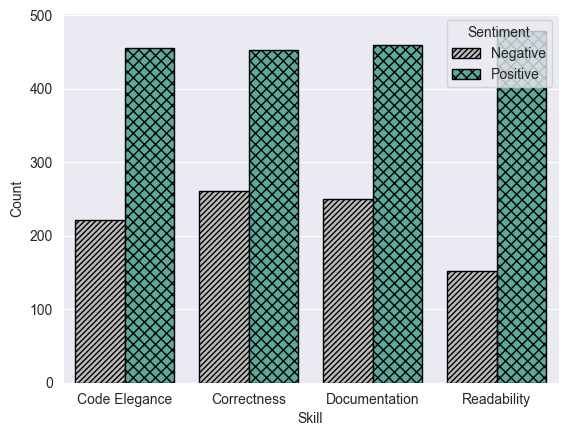

In [437]:
g = sns.barplot(sentiment_df, x='skill', y='count', hue='sentiment')


hatches = ['//', 'x',]
colors = [grey, teal]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, g.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

g.set(xlabel='Skill', ylabel='Count')
handles = g.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')

g.legend(title='Sentiment')
g.get_figure().savefig('../plots/sentiment.pdf', bbox_inches='tight')

### LDA Topic Analysis
https://link.springer.com/article/10.1007/s44217-023-00051-0
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9260886/

Code adapted from: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#4.-Build-the-Bigram,-Trigram-Models-and-Lemmatize

In [438]:

text_data = nlp_df[nlp_df['skill'] == 'Readability']['comments']

In [439]:
bigram = Phrases(text_data, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[text_data], threshold=100)
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

In [440]:
# TODO: Build LDA for correctness, readability and maintainability

In [441]:
processed_text = process_words(text_data, stem=False, allowed_postags=['NOUN'])
dictionary = corpora.Dictionary(processed_text)
dictionary.filter_extremes(no_below=15, no_above=0.3, keep_n=10000)
corpus = [dictionary.doc2bow(text) for text in processed_text]

model = TfidfModel(corpus)
tfidf_corpus = [model[i] for i in corpus]

In [442]:
def generate_topic_models(corpus, dictionary, num_topics=5):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=10, passes=15)
    cm = CoherenceModel(model=lda_model, texts=processed_text, coherence='u_mass')
    coherence = cm.get_coherence()
    return lda_model, coherence


In [443]:
models = {}
coherence_results = []

for topic_count in tqdm([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 100]):
    model, coherence = generate_topic_models(tfidf_corpus, dictionary, topic_count)
    models[str(topic_count)] = model
    coherence_results.append({'topic_count':topic_count, 'coherence': coherence})
    
coherence_df = pd.DataFrame(coherence_results)
coherence_df

100%|██████████| 15/15 [00:04<00:00,  3.01it/s]


,topic_count,coherence
0,1,-9.973276
1,2,-11.021087
2,3,-10.291943
3,4,-9.616342
4,5,-9.400095
5,6,-10.160412
6,7,-9.310493
7,8,-9.837167
8,9,-9.744100
9,10,-10.077557


<Axes: xlabel='topic_count', ylabel='coherence'>

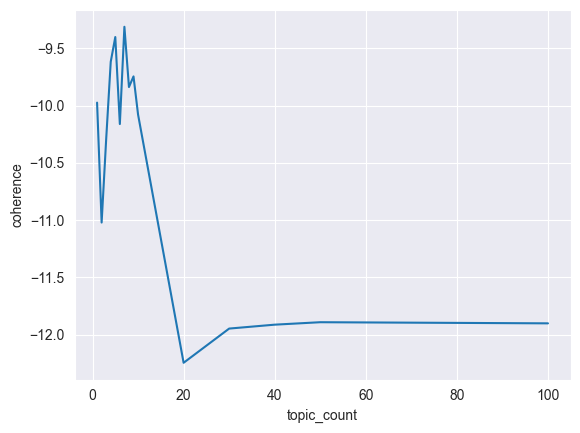

In [444]:
sns.lineplot(coherence_df, x='topic_count', y='coherence')

In [445]:
topic_count = '5'
vis = pyLDAvis.gensim.prepare(models[topic_count], corpus, dictionary=models[topic_count].id2word)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.205511  0.322199       1        1  25.592433
4     -0.309631  0.011572       2        1  24.457240
1      0.189396 -0.317465       3        1  18.135980
2     -0.200914  0.001958       4        1  17.569234
3      0.115638 -0.018265       5        1  14.245113, topic_info=         Term        Freq       Total Category  logprob  loglift
24   function  225.000000  225.000000  Default  26.0000  26.0000
14     naming  158.000000  158.000000  Default  25.0000  25.0000
3       class  126.000000  126.000000  Default  24.0000  24.0000
15   variable   78.000000   78.000000  Default  23.0000  23.0000
16    comment   78.000000   78.000000  Default  22.0000  22.0000
..        ...         ...         ...      ...      ...      ...
15   variable    0.440977   78.672198   Topic5  -6.1078  -3.2353
25  structure    0.434007   83.891537   Topic5  -6.1237  -3.3155
3       class    0.460465  126.172576   Topic5  -6.0645  -3.6644
14     naming    0.450972  158.606198   Topic5  -6.0854  -3.9140
24   function    0.436628  225.703472   Topic5  -6.1177  -4.2991

[156 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2         4  0.021613        access
2         5  0.972591        access
18        3  0.920531   application
18        4  0.051141   application
10        4  0.030152         block
10        5  0.934715         block
3         1  0.982781         class
3         4  0.007926         class
21        4  0.421361      codebase
16        4  0.978578       comment
13        3  0.959935    convention
13        4  0.029998    convention
0         4  0.061439        follow
0         5  0.921591        follow
24        2  0.992453      function
24        4  0.004431      function
19        3  0.929151    identifier
19        4  0.040398    identifier
4         2  0.723013   indentation
4         4  0.258219   indentation
20        3  0.569709         issue
20        4  0.189903         issue
22        4  0.964300         level
5         1  0.966030        method
5         4  0.017889        method
6         4  0.021397      modifier
6         5  0.962883      modifier
14        3  0.989873        naming
14        4  0.006305        naming
1         4  0.315570     operation
1         5  0.315570     operation
23        4  0.929954  organisation
11        2  0.728916        public
11        4  0.182229        public
8         1  0.957299          read
8         4  0.028156          read
12        1  0.968405          self
12        4  0.018623          self
17        3  0.882207         space
17        4  0.067862         space
25        1  0.977453     structure
25        4  0.011920     structure
9         2  0.958187           use
9         4  0.019962           use
15        4  0.978745      variable
7         4  0.018638    whitespace
7         5  0.969172    whitespace, R=26, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 2, 3, 4])

IndexError: list index out of range

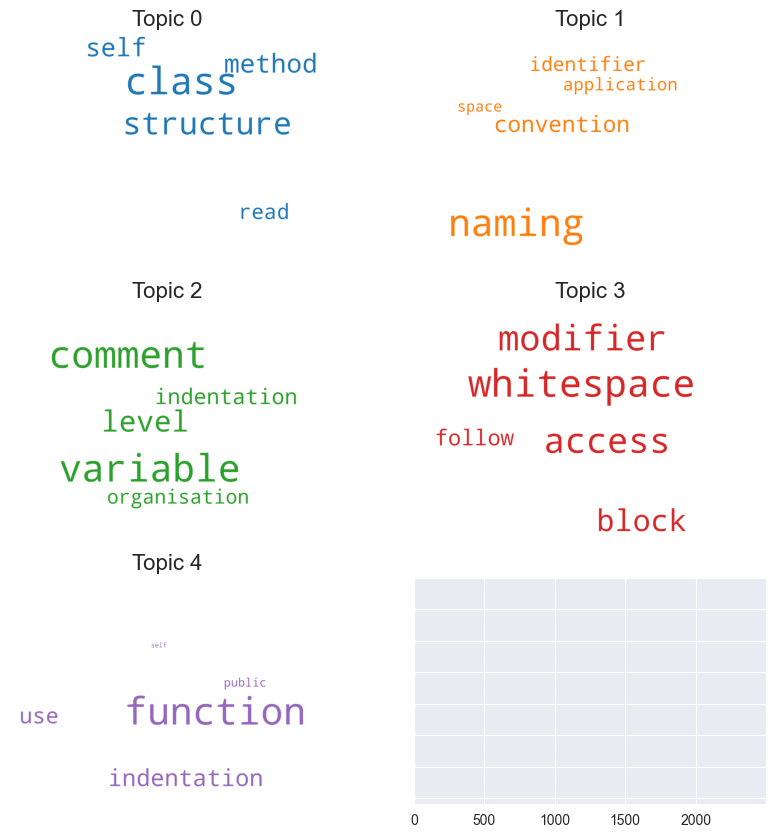

In [448]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = models[topic_count].show_topics(formatted=False, num_words=5)

fig, axes = plt.subplots((int(topic_count) // 2) + int(topic_count) % 2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()